# Dog Breeds
https://www.kaggle.com/c/dog-breed-identification

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

# Build the model

Set the paths to the home folder of the dataset. Set the batch size to start with.

In [4]:
PATH = "data/dogbreeds/"
sz = 224

Set the validation indices and give it to the learner. Define augmentations and pass it to data loader.

In [20]:
val_idxs = get_cv_idxs(10222, cv_idx=3)

arch = resnet152
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

data = ImageClassifierData.from_csv(PATH, folder="train", csv_fname=f"{PATH}labels.csv", val_idxs=val_idxs,
                                    bs=64, tfms=tfms, suffix=".jpg", test_name="test")
# learn = ConvLearner.pretrained(arch, data, precompute=False)
# learn.fit(0.01, 3)

The above model is a quick model build using resnet152 (where we are only adjusting weights of final layers). But, we can do much better.

Let's tweak the weights of the inner layers a bit more and see what happens. Before that, we have to figure out how much to tweak. So, let's find the learning rate by taking a fresh model.

In [21]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf = learn.lr_find()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/ubuntu/.torch/models/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:03<00:00, 75225401.40it/s]


100%|██████████| 162/162 [00:38<00:00,  4.22it/s]


A Jupyter Widget

 84%|████████▎ | 107/128 [00:01<00:00, 104.81it/s, loss=16.3]


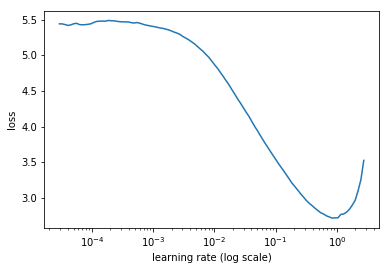

In [22]:
learn.sched.plot()

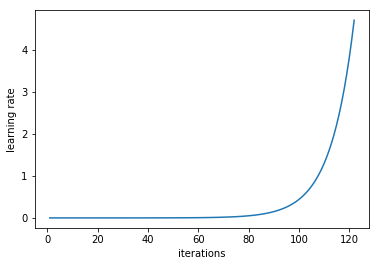

In [23]:
learn.sched.plot_lr()

In [24]:
tfms = tfms_from_model(resnet152, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

A Jupyter Widget

[ 0.       1.10431  0.51286  0.87259]                        
[ 1.       0.54196  0.42037  0.88197]                         
[ 2.       0.39298  0.38981  0.8834 ]                         



In [25]:
learn.precompute = False

In [26]:
learn.fit(0.01, 3, cycle_len=1)

A Jupyter Widget

[ 0.       0.40033  0.37029  0.88242]                        
[ 1.       0.36614  0.36419  0.87998]                        
[ 2.       0.36388  0.35971  0.8819 ]                        



Let's plot the learning rate. As we have given `cycle_len=1`, the lr should reset after every iteration.

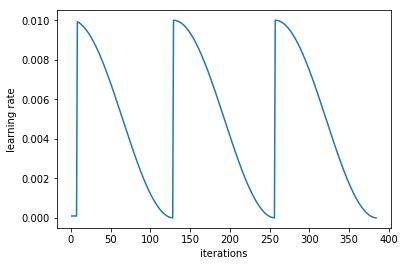

In [27]:
learn.sched.plot_lr()

In [28]:
learn.save("dogbreeds_1")

In [29]:
learn.load("dogbreeds_1")

# Differential learning rates

In [30]:
learn.unfreeze()

As we have unfreezed all the layers, when we train the network, the weights of all the layers are updated. While we'd like to change the weights of later layers by a fair margin, we want to ensure we don't fiddle too much with the weights of the earlier layers. So, we give different learning rates for each layer.

Here, we divide the layers into three logical groups - early conv layers, mid conv layers and end fc layers. We give 3 different lr's to each of these.

In [31]:
lr = np.array([1e-4, 1e-3, 1e-2])

In [32]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.43924  0.40395  0.87213]                        
[ 1.       0.37665  0.39702  0.87647]                        
[ 2.       0.27489  0.39003  0.87757]                        
[ 3.       0.29676  0.4279   0.85944]                        
[ 4.       0.24113  0.40376  0.88047]                        
[ 5.       0.18409  0.39994  0.88636]                        
[ 6.       0.16041  0.39817  0.88441]                        



A Jupyter Widget

 60%|██████    | 77/128 [00:59<00:39,  1.29it/s, loss=0.44] 

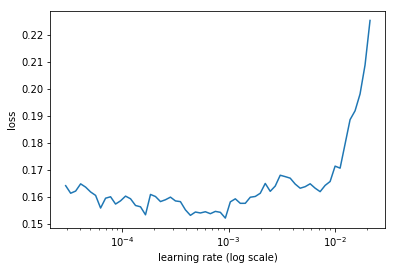

In [33]:
lrf=learn.lr_find()
learn.sched.plot()

In [34]:
lr = np.array([1e-10, 1e-7, 1e-5])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

                                                           
                                                           
                                                           
                                                           
                                                           
                                                           
                                                           
                                                           

                                                           
                                                           
                                                           
                                                           
                                                           

                                                           
                                                           

  5%|▌         | 7/128 [00:08<02:29,  1.24s/it, loss=0.173]

  6%|▋         | 8/128 [00:09<02:20,

Exception in thread Thread-56:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Exception in thread Thread-57:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[ 0.       0.14894  0.39562  0.88779]                        
[ 1.       0.14309  0.39547  0.88636]                        
[ 2.       0.14925  0.39614  0.88392]                        
[ 3.       0.14443  0.3971   0.88441]                        
[ 4.       0.15483  0.39866  0.88493]                        
[ 5.       0.15266  0.39744  0.88688]                        
[ 6.       0.15361  0.39392  0.88538]                        



# Predict on test set

In [ ]:
#preds = np.exp(learn.predict(is_test=True))

In [ ]:
#fnames = [x.split("/")[1].split(".")[0] for x in data.test_dl.dataset.fnames]

In [ ]:
#final = pd.read_csv(f"{PATH}/sample_submission.csv")
#final.loc[:,1:] = preds

In [ ]:
#f = "submit1.csv"
#final.to_csv(f"{PATH}{f}", compression="gzip", index=False)

#from IPython.display import FileLink
#FileLink(f"{PATH}{f}")